<a href="https://colab.research.google.com/github/JasonYen-tw/CNN-Assignment-2025/blob/main/ACS111147_CNN_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACS111147 - CNN 卷積神經網路實作 (CIFAR-10)

## 專案描述

這個專案的目標是在 CIFAR-10 數據集上訓練一個卷積神經網路（CNN）。CIFAR-10 包含 10 個類別的 32x32 彩色圖片，分別是：飛機、汽車、鳥、貓、鹿、狗、青蛙、馬、船和卡車。

## 實作重點

1. **模型架構**：採用一個包含多個卷積層、ReLU 激活函數、Batch Normalization、MaxPooling 和 Dropout 的深度 CNN 模型，用以提取圖像特徵並提升模型穩定性。
2. **資料預處理**：將圖片像素值標準化到 \[-0.5, 0.5] 區間，並對標籤進行 One-Hot 編碼。
3. **資料增強 (Data Augmentation)**：使用 `ImageDataGenerator` 對訓練圖片進行即時的隨機旋轉、平移和水平翻轉，以提高模型的泛化能力。
4. **模型訓練**：使用 Adamax 優化器和一個學習率排程器（Learning Rate Scheduler）來動態調整學習率，以達到更好的收斂效果。
5. **自動化評分**：訓練完成後，模型會評估其在測試集上的表現，並將準確率、損失值等關鍵指標寫入 `model_accuracy.txt` 檔案中，以供 GitHub 自動化評分系統讀取。

In [ ]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

TensorFlow Version: 2.18.0
Keras Version: 3.8.0


訓練資料維度: (50000, 32, 32, 3) (50000, 1)
測試資料維度: (10000, 32, 32, 3) (10000, 1)


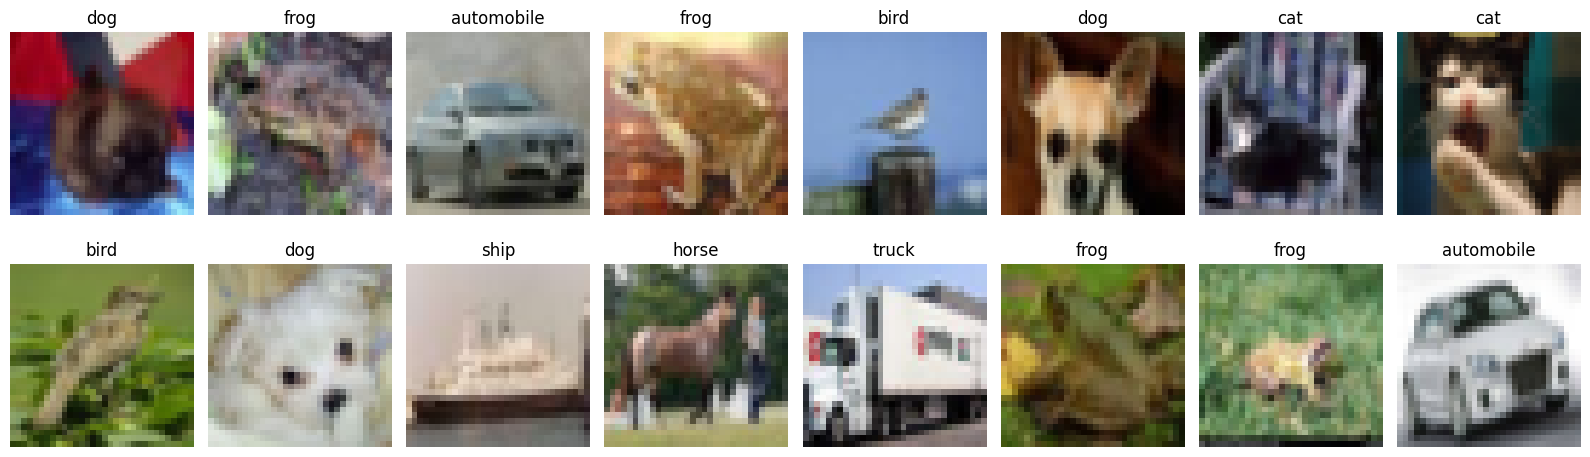

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

print("訓練資料維度:", x_train.shape, y_train.shape)
print("測試資料維度:", x_test.shape, y_test.shape)

class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

cols = 8
rows = 2
plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols * rows):
    random_index = np.random.randint(0, len(y_train))
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(x_train[random_index, :])
    ax.set_title(class_names[y_train[random_index, 0]])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
x_train_norm = (x_train / 255.0) - 0.5
x_test_norm = (x_test / 255.0) - 0.5

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

print("標準化後訓練圖片維度:", x_train_norm.shape)
print("One-Hot 編碼後訓練標籤維度:", y_train_cat.shape)

標準化後訓練圖片維度: (50000, 32, 32, 3)
One-Hot 編碼後訓練標籤維度: (50000, 10)


In [ ]:

INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)

model = models.Sequential([
    # First Conv Block
    Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second Conv Block
    Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third Conv Block
    Conv2D(filters=128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Fully connected layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,084,234 (4.14 MB)

 Trainable params: 1,084,234 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 50

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adamax(learning_rate=INIT_LR),
    metrics=['accuracy']
)

def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

In [12]:
train_generator = data_generator.flow(x_train_norm, y_train_cat, BATCH_SIZE)
steps_per_epoch = len(x_train) // BATCH_SIZE

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    callbacks=[LearningRateScheduler(lr_scheduler)],
    validation_data=(x_test_norm, y_test_cat),
    verbose=1
)

Epoch 1/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 205s 130ms/step - accuracy: 0.3765 - loss: 1.7053 - val_accuracy: 0.6156 - val_loss: 1.0739 - learning_rate: 0.0050
Epoch 2/25
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:36 100ms/step - accuracy: 0.5938 - loss: 1.3490

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5938 - loss: 1.3490 - val_accuracy: 0.6140 - val_loss: 1.0778 - learning_rate: 0.0045
Epoch 3/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 261s 134ms/step - accuracy: 0.5820 - loss: 1.1748 - val_accuracy: 0.6550 - val_loss: 0.9858 - learning_rate: 0.0041
Epoch 4/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6562 - loss: 1.0201 - val_accuracy: 0.6540 - val_loss: 0.9955 - learning_rate: 0.0036
Epoch 5/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 245s 130ms/step - accuracy: 0.6356 - loss: 1.0334 - val_accuracy: 0.6726 - val_loss: 0.9235 - learning_rate: 0.0033
Epoch 6/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5938 - loss: 1.1245 - val_accuracy: 0.6692 - val_loss: 0.9317 - learning_rate: 0.0030
Epoch 7/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 205s 131ms/step - accuracy: 0.6689 - loss: 0.9413 - val_accuracy: 0.7162 - val_loss: 0.8400 - learning_rate: 0.0027
Epoch 8/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7500

In [13]:
test_loss, test_acc = model.evaluate(x_test_norm, y_test_cat, verbose=2)

try:
    with open('model_accuracy.txt', 'w') as f:
        f.write("Model Performance Summary:\n")
        f.write(f"Test Accuracy: {test_acc:.4f}\n")
        f.write(f"Test Loss: {test_loss:.4f}\n")
        f.write(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}\n")
        f.write(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}\n")
        f.write(f"Final Training Loss: {history.history['loss'][-1]:.4f}\n")
        f.write(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}\n")
        f.write(f"Training Epochs: {len(history.history['accuracy'])}\n")
        f.write(f"Model Parameters: {model.count_params()}\n")

    with open('model_accuracy.txt', 'r') as f:
        print("\n--- Content of model_accuracy.txt ---")
        print(f.read())
except Exception as e:
    print(f"Error writing to file: {e}")

313/313 - 10s - 30ms/step - accuracy: 0.7605 - loss: 0.7015

--- Content of model_accuracy.txt ---
Model Performance Summary:
Test Accuracy: 0.7605
Test Loss: 0.7015
Final Training Accuracy: 0.7505
Final Validation Accuracy: 0.7605
Final Training Loss: 0.7161
Final Validation Loss: 0.7015
Training Epochs: 25
Model Parameters: 1084234



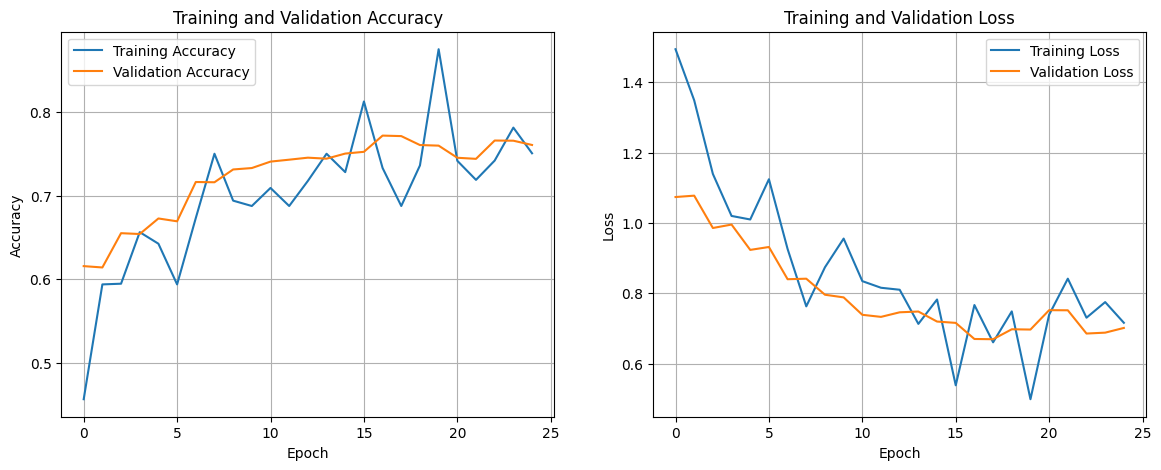

In [14]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


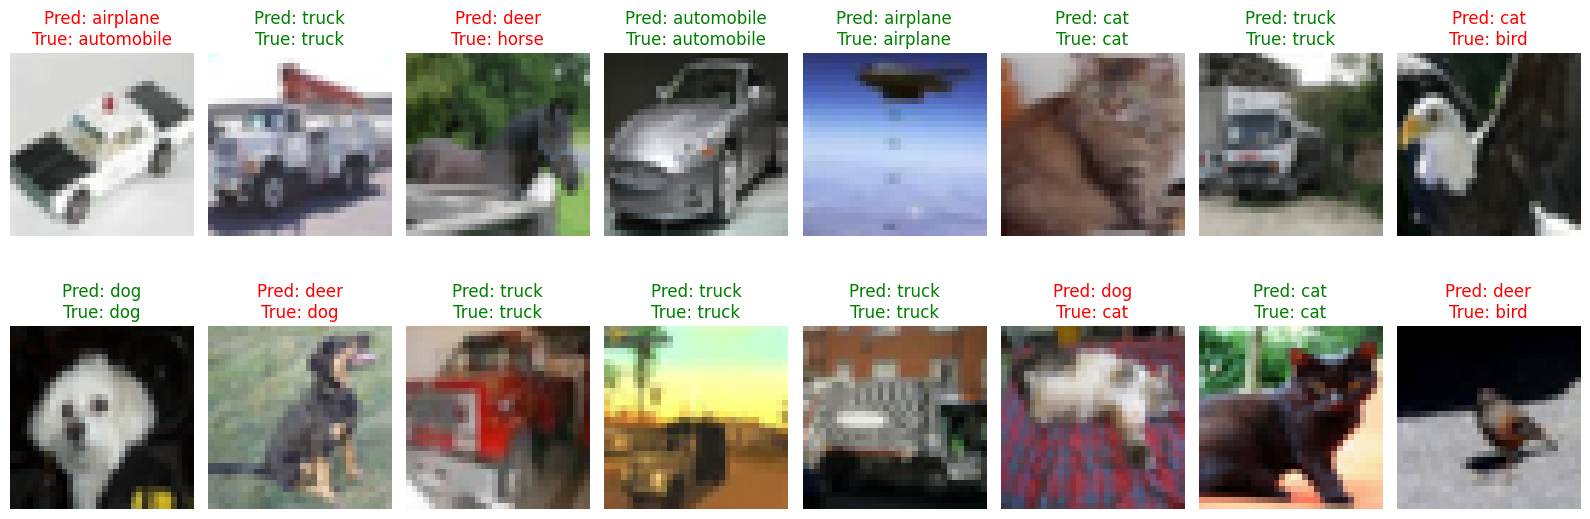

In [15]:
predictions = model.predict(x_test_norm)
predicted_labels = np.argmax(predictions, axis=1)

cols = 8
rows = 2
plt.figure(figsize=(2 * cols, 3 * rows))
for i in range(cols * rows):
    random_index = np.random.randint(0, len(y_test))
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(x_test[random_index, :])
    pred_label = class_names[predicted_labels[random_index]]
    true_label = class_names[y_test[random_index, 0]]
    title_color = 'g' if pred_label == true_label else 'r'
    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", color=title_color)
    ax.axis('off')
plt.tight_layout()
plt.show()